# EDABE LSTM-1D CNN Example

The following code shows how to use the EDABE LSTM-1D CNN model to correct artifacts automatically in Electrodermal Activity (EDA) signal.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
import scipy.interpolate as sc_int 

### Deep Learning libraries
import tensorflow as tf
import keras

import keras.backend as K
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Input, GRU
from keras.layers import BatchNormalization, Lambda, Add, concatenate, Reshape
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,TensorBoard
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.losses import binary_crossentropy

### Model architecture

In [2]:
def model_recognition(window, dropout_value = 0.05):
    
    filter_size = 32 
    kernel_size = 5

    model = Sequential()
    
    inputs = Input((window, 1))
    
    # ### LSTM layers ###
    
    lstm1 = LSTM(16, activation="tanh", return_sequences=True)(inputs)
    lstm1 = BatchNormalization()(lstm1)
    lstm1_drop = Dropout(dropout_value)(lstm1)

    lstm2 = LSTM(16, activation="tanh", return_sequences=True)(lstm1_drop)
    lstm2 = BatchNormalization()(lstm2)
    lstm2_drop = Dropout(dropout_value)(lstm2)

    # ### 1D CNN layers ###
    
    conv1 = Conv1D(filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(lstm2_drop)
    conv1 = BatchNormalization()(conv1)
    conv1_1 = Conv1D(filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv1)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv1D(filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    drop1 = Dropout(dropout_value)(conv1_2)
    add1 = Add()([drop1, conv1])
    max1 = MaxPooling1D(pool_size=2)(add1)
    
    conv2 = Conv1D(2*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(max1)
    conv2 = BatchNormalization()(conv2)
    conv2_1 = Conv1D(2*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv2)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv1D(2*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    drop2 = Dropout(dropout_value)(conv2_2)
    add1 = Add()([drop2, conv2])
    max2 = MaxPooling1D(pool_size=2)(add1)
    
    conv3 = Conv1D(4*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(max2)
    conv3 = BatchNormalization()(conv3)
    conv3_1 = Conv1D(4*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv3)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv1D(4*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    drop3 = Dropout(dropout_value)(conv3_2)
    add3 = Add()([drop3, conv3])
    max3 = MaxPooling1D(pool_size=2)(add3)

    conv4 = Conv1D(8*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(max3)
    conv4 = BatchNormalization()(conv4)
    conv4_1 = Conv1D(8*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv4)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv1D(8*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    drop4 = Dropout(dropout_value)(conv4_2)
    add4 = Add()([drop4, conv4])
    max4 = MaxPooling1D(pool_size=2)(add4)

    conv5 = Conv1D(16*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(max4)
    conv5 = BatchNormalization()(conv5)
    conv5_1 = Conv1D(16*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv5)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv1D(16*filter_size, kernel_size, activation='relu', padding = 'same',
                   kernel_initializer = 'he_normal')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    drop5 = Dropout( dropout_value )(conv5_2)
    add5 = Add()([drop5, conv5])
    max5 = MaxPooling1D(pool_size=2)(add5)
        
    flat = Flatten()(max4)
    
    # ### Dense layers ###
    
    dense1 = Dense(256, activation = "relu")(flat)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    
    dense2 = Dense(16, activation="relu")(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.5)(dense2)
    
    dense3 = Dense(1, activation="sigmoid")(dense2) 
    
    model = Model(inputs, dense3)
        
    return model

In [8]:
# Initialize the model
EDABE_LSTM_1DCNN_Model = model_recognition(window=5*128, dropout_value=0.05)

# Loading the weights of the DL model 
EDABE_LSTM_1DCNN_Model.load_weights("Model/EDABE_LSTM_1DCNN_Model.h5")

### Functions definition

The following chuncksof code define different functions that complete the pre-processing of the signal to introduce it to the model or post-process the output to obtain the corrected EDA signal.

In [18]:
# "charge_raw_data" pre-process the input signal cutting the signal in pieces of 5 seconds. In the case that a target is 
# introduced (y_col != None), the target is cut the last 0.5 seconds of the binary target, 
# becoming the target of the correspondent 5 seconds segement.
def charge_raw_data(df, x_col="rawdata", target_size_frames=64, y_col=None, freq_signal=128, verbose=False):
    
    x_signal = df[x_col].values
    if y_col is not None:
        y_signal = df[y_col].values
    
    window_size = 5 * freq_signal

    x_window_list, y_window_list = [], []
    
    i = 0
    while i <= len(x_signal)-window_size:
        
        denominator_norm = (np.nanmax(x_signal[i:(i+window_size)])-np.nanmin(x_signal[i:(i+window_size)]))
        
        x_signal_norm = (x_signal[i:(i+window_size)]-np.nanmin(x_signal[i:(i+window_size)]))/denominator_norm
        x_window_list.append( x_signal_norm )
        
        if y_col is not None:
            cond = np.nanmean( y_signal[(i+window_size-target_size_frames):(i+window_size)] ) > 0.5
            y_window_list.append( 1 if cond else 0)

        if i % 50000 == 0 and verbose:
            print("Iteration", i, "of", len(x_signal)-window_size-1, end="\r")
        
        i += target_size_frames
    
    return np.array(x_window_list), np.array(y_window_list)

# This function only defines the position in an array or list where it is a True value.
def which_element(object_list):
    result = [i_obj for i_obj, obj in enumerate(object_list) if obj]
    return result

# This function defines where it is found the first and the last 1 of a sequence of ones (1s) in a binary vector where. 
# For example: X = [0, 0, 1, 1, 1, 0, 0, 1, 1]. This function will found as a result the following: 
# find_begin_end(X) = [2, 7], [4, 8]. It means that at positions 2 and 7 of X it begins a sequence of 1s. On the other hand, 
# 4 and 8 are the positions where these sequences ends. This function is necessary to localize the position of the 
# artifacts in the raw binary signal of the target or the prediction.
def find_begin_end( x_p ):
    
    pos_artf_true = which_element( x_p == 1 )

    start_pos_artf_true = [ pos_artf_true[0] ]
    for i, p_art_t in enumerate( pos_artf_true[1:] ):
        if p_art_t-pos_artf_true[i] > 1:
            start_pos_artf_true.append( p_art_t )

    end_pos_artf_true = [
        p_art_t for i, p_art_t in enumerate( pos_artf_true[:-1] ) if pos_artf_true[i+1]-p_art_t > 1
    ]

    end_pos_artf_true.append( pos_artf_true[-1] )
    
    return start_pos_artf_true, end_pos_artf_true


def down_sample(x, f = 16):
    result = []
    for i in np.arange(len(x)/f):
        result += [ np.nanmean( x[int(i*f):int((i+1)*f)] ) ]

    return result


def moving_average(array, window_size=7):
    final_list = array[:int(window_size/2)].tolist()
    
    for i in range(int(window_size/2), len(array)-int(window_size/2)):
        value = np.mean(array[i-int(window_size/2):i+int(window_size/2)])
        final_list += [value]
        
    final_list += array[-int(window_size/2):].tolist()
    
    return np.array(final_list)

In [19]:
def automatic_EDA_correct(df, model, 
                          freq_signal=128, th_t_postprocess=2.5, 
                          eda_signal="uS", time_column="UnixTimestamp"):

    target_size_fr = 64

    df[eda_signal][df[eda_signal] < 0] = 0
    
    df["signal_automatic"] = df[eda_signal].iloc[:]
    rawdata_spline_correct = df[eda_signal].iloc[:]

    x, _ = charge_raw_data( df, x_col=eda_signal, target_size_frames=target_size_fr)
    
    x_res = np.resize(x, (x.shape[0], x.shape[1], 1))
    
    ######################################
    ### AUTOMATIC ARTIFACT RECOGNITION ###
    ######################################
    
    with tf.device('/cpu:0'):
        y_pred = model.predict(x_res, verbose=1)
    
    y_pred[y_pred <= 0.2] = 0
    y_pred[y_pred > 0.2] = 1
    
    y_pred[np.isnan(y_pred)] = 0
    
    future_labels_auto = np.zeros( df.shape[0] )

    for i_label, label in enumerate(y_pred[:,0]):
        future_labels_auto[ target_size_fr*i_label:target_size_fr*(i_label+1) ] += label
    
    ##############################
    ### TARGET POST-PROCESSING ###
    ##############################

    pred_target_array = df[eda_signal].iloc[:].copy()
    
    future_labels_auto[future_labels_auto > 0] = 1
    pred_target_array = future_labels_auto

    df["PredArtifacts"] = pred_target_array

    start_artf_pred, end_artf_pred = find_begin_end( pred_target_array )
    
    for i in range( len(start_artf_pred)-1 ):
        if np.abs(start_artf_pred[i+1] - end_artf_pred[i])/freq_signal <= th_t_postprocess:
            pred_target_array[ end_artf_pred[i]:start_artf_pred[i+1] ] = 1
    
    start_artf_pred, end_artf_pred = find_begin_end( pred_target_array )
    
    df["PostProcessedPredArtifacts"] = pred_target_array
    
    # #################################
    # ### Compute artifacts metrics ###
    # #################################
    
    dict_metrics = {}
    
    # Time until first artifact.
    dict_metrics["time_first_artifact"] = start_artf_pred[0]/freq_signal
    
    # Mean time between two artifacts.
    t_btw_artf = ( np.array(start_artf_pred)[1:]-np.array(end_artf_pred)[:-1] )/freq_signal
    dict_metrics["time_between_artifact"] = np.mean(t_btw_artf)
    
    # Mean duration of the detected artifacts.
    dur_time_artf_subj_train = (np.array(end_artf_pred)-np.array(start_artf_pred))/freq_signal
    dict_metrics["mean_artifact_duration"] = np.mean(dur_time_artf_subj_train)
    
    # Minimum duration time of an artifact.
    dict_metrics["minimum_artifact_duration"] = np.min(dur_time_artf_subj_train)
    
    # Percentage of artifacts in the signal.
    perc_of_artf = 100 * np.sum( pred_target_array )/df.shape[0]
    dict_metrics["percentage_of_artifacts"] = perc_of_artf
    
    # Total number of artifacts in the signal.
    n_artf_obtain = len(start_artf_pred)
    dict_metrics["number_of_artifacts"] = n_artf_obtain

    # print( "Number of artefacts predicted post-processed", n_artf_obtain )
    
    # print("Beginning of the interpolation")
    
    ############################
    ### AUTOMATIC CORRECTION ### 
    ############################
    
    start_artf, end_artf = find_begin_end( pred_target_array )
    
    begin_bad_elements = start_artf
    end_bad_elements = end_artf
    
    for ctr_it in range( len(end_bad_elements) ):        
        
        begin_index = begin_bad_elements[ctr_it]-int(freq_signal/4)
            
        if begin_index < 0:
            begin_index = 0
            
        end_index = end_bad_elements[ctr_it]+int(freq_signal/4)
                      
        to_clean_segment = df[time_column].iloc[begin_index:end_index]
        
        to_plot = to_clean_segment
        to_clean = df[eda_signal].iloc[to_clean_segment.index.values]
        
        th_init_space = 0 if begin_bad_elements[ctr_it] == 0 else int(freq_signal/4)-1
        
        th_end_space = int(freq_signal/4)
        
        initl_pnt = to_clean.iloc[th_init_space]
        final_pnt = to_clean.iloc[-th_end_space]

        x_all_int = to_clean.index.values
        x_int = to_clean[th_init_space:-th_end_space].index.values
        y_int = to_clean[th_init_space:-th_end_space].values
        
        #########################
        ### SPLINE CORRECTION ###
        #########################

        f = interp1d([x_int[0], x_int[-1]], [y_int[0], y_int[-1]], kind="linear")
        
        intermediam_correct_lineal = f(x_int)
        init_correct = to_clean.iloc[:th_init_space] 
        final_correct = to_clean.iloc[-th_end_space:]
            
        x_to_spline = [x_int[0]]+down_sample(x_int, f = x_int.shape[0]/8)+[x_int[-1]]
        y_to_spline = [y_int[0]]+down_sample(y_int, f = y_int.shape[0]/8)+[y_int[-1]]
            
        y_output = sc_int.spline( x_to_spline, y_to_spline, x_int )

        mix_curve = np.mean([intermediam_correct_lineal, y_output], axis=0)
        
        tuple_concat = (mix_curve, final_correct) if init_correct.shape[0] < 2 else (init_correct, mix_curve, final_correct)
        correct_linear = np.concatenate(tuple_concat, axis=0)
        
        df["signal_automatic"].iloc[to_clean_segment.index.values] = moving_average(correct_linear, freq_signal/8 )

    return df, dict_metrics

### Read data example

In [20]:
df_ex = pd.read_csv("Data/Corrected_oxused_expert2.csv", sep=";")
df_ex

,time,rawdata,cleandata,binarytarget,signal_automatic,PredArtifacts,PostProcessedPredArtifacts
0,0.000000,0.000000,-0.091119,0.0,0.000000,0.0,0.0
1,0.007812,0.000000,-0.091119,0.0,0.000000,0.0,0.0
2,0.015625,0.000000,-0.091119,0.0,0.000000,0.0,0.0
3,0.023438,0.000000,-0.091119,0.0,0.000000,0.0,0.0
4,0.031250,0.000000,-0.091119,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
765040,5976.875000,0.011766,0.011766,0.0,0.011766,0.0,0.0
765041,5976.882812,0.011322,0.011322,0.0,0.011322,0.0,0.0
765042,5976.890625,0.011322,0.011322,0.0,0.011322,0.0,0.0
765043,5976.898438,0.011766,0.011766,0.0,0.011766,0.0,0.0


### Correct the EDA signal

In [24]:
df_result, dict_metrics = automatic_EDA_correct(df_ex, EDABE_LSTM_1DCNN_Model, 
                                                freq_signal=128, th_t_postprocess=2.5,
                                                eda_signal="rawdata", time_column="time")

11944/11944 [==============================] - 54s 5ms/step


C:\Users\Jose\Desktop\LabLENI\DescriptionEDA\Code\venv\lib\site-packages\ipykernel_launcher.py:125: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


In [26]:
# This table is a set of different metrics obtained over the detected artifacts in the EDA signal.

pd.DataFrame(dict_metrics, index=[0])

,time_first_artifact,time_between_artifact,mean_artifact_duration,minimum_artifact_duration,percentage_of_artifacts,number_of_artifacts
0,2.5,23.83669,8.042719,0.492188,25.322432,188


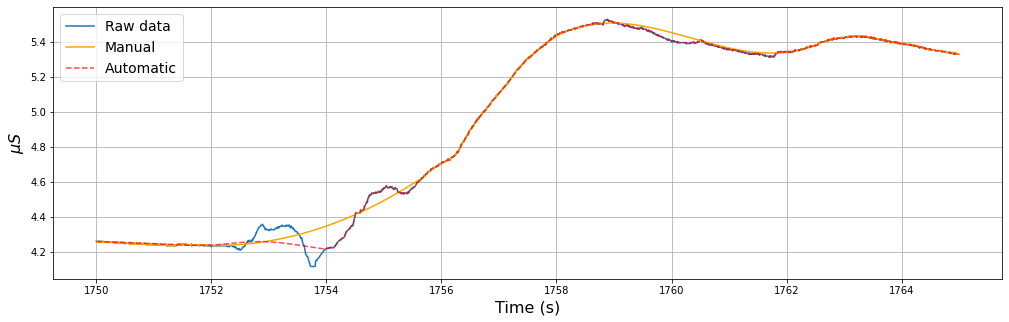

In [36]:
# This code shows a piece of the signal corrected by the EDABE LSTM-1D CNN Model.

plt.figure(figsize=(17, 5))

begin_time_s, end_time_s = 1750, 1765

begin_sample, end_sample = begin_time_s * 128, end_time_s * 128

time_to_plot = df_result["time"].iloc[begin_sample:end_sample]

rawdata_to_plot = df_result["rawdata"].iloc[begin_sample:end_sample]
cleandata_to_plot = df_result["cleandata"].iloc[begin_sample:end_sample]
autodata_to_plot = df_result["signal_automatic"].iloc[begin_sample:end_sample]    

plt.plot(time_to_plot, rawdata_to_plot, label="Raw data")
plt.plot(time_to_plot, cleandata_to_plot, label="Manual", c="orange")
plt.plot(time_to_plot, autodata_to_plot, label="Automatic", alpha=0.7, linestyle="--", c="red")
        
plt.legend(fontsize=14)
plt.grid()
        
plt.ylabel(r'$\mu S$', fontsize=16)
plt.xlabel("Time (s)", fontsize=16)

plt.show()